# Monetary Policy Impulse Notebook

## Copying the necessary stuff

In [1]:
using PyPlot

In [2]:
include("het.jl")
include("graph.jl")

construct (generic function with 1 method)

In [3]:

# NOTE: Z is technically Y

""" I. Specifies the ins and outs of each block in the DAG"""

ins_outs = [
    Dict("ins" => ["r_ante"], "outs" => ["r"]), # no-val block
    Dict("ins" => ["r", "Z"], "outs" => ["C", "A"]), # ha block
    Dict("ins" => ["A", "C", "Z"], "outs" => ["asset_mkt", "goods_mkt"]), # goods market clearing block
]

""" II. Defining the no-val block """

dict_in_ex_post_rate = Dict{Any, Any}(
    "r_ante" => 0.01,
)
dict_out_ex_post_rate = Dict{Any, Any}(
    "r" => nothing
)

function f_ex_post_rate(block::Block)
    r_ante = block.ins["r_ante"]
    r = r_ante
    block.outs["r"] = r
end

# ex_post_rate_block = Block(dict_in_ex_post_rate, dict_out_ex_post_rate, f_ex_post_rate, ins_outs, "No-Val")

""" III. Defining the ha block """

hh_block = HH_Block(Dict{Any, Any}("r" => nothing, "Z" => 1.0), Dict{Any, Any}("C" => nothing), "HA", []) # Defining a placeholder for the heterogeneous agent block

""" IV. Defining the goods market clearing block """

dict_in_mkt_clearing_simple = Dict{Any, Any}(
    "A" => nothing,
    "C" => nothing,
    "Z" => 1.0
)
dict_out_mkt_clearing_simple = Dict{Any, Any}(
    "asset_mkt" => nothing,
    "goods_mkt" => nothing
)

function f_mkt_clearing_simple(block::Block)
    A, C, Z = block.ins["A"], block.ins["C"], block.ins["Z"]
    asset_mkt = A
    goods_mkt = C - Z
    block.outs["asset_mkt"] = asset_mkt
    block.outs["goods_mkt"] = goods_mkt
end

mkt_clearing_simple_block = Block(dict_in_mkt_clearing_simple, dict_out_mkt_clearing_simple, f_mkt_clearing_simple, ins_outs, "Clearing")

""" V. Creating the DAG """

mon_DAG =  DAG_Rep([hh_block, mkt_clearing_simple_block])

calibration = Dict("eis" => 0.5,     # EIS
                   "rho_e" => 0.92,  # Persistence of idiosyncratic productivity shocks
                   "sd_e" => 0.92,   # Standard deviation of idiosyncratic productivity shocks
                   "Z" => 1.0,       # Output
                   "r_ante" => 0.01, # target real interest rate
                   "min_a" => -1.0,  # Minimum asset level on the grid
                   "max_a" => 1_000, # Maximum asset level on the grid
                   "n_a" => 300,     # Number of asset grid points
                   "n_e" => 11,      # Number of productivity grid points
                   "beta" => 0.85)     

inputs_to_hh = Dict("eis" => calibration["eis"], 
                    "rho_e" => calibration["rho_e"],
                    "sd_e" => calibration["sd_e"],
                    "r" => calibration["r_ante"],
                    "min_a" => calibration["min_a"],
                    "max_a" => calibration["max_a"],
                    "n_a" => calibration["n_a"],
                    "n_e" => calibration["n_e"],
                    "beta" => calibration["beta"])

ss_vals, hh_ss_all_vals = DAG_get_ss(mon_DAG, "None", inputs_to_hh, "mon_beta")

(Dict{Any, Any}("A" => -6.040038796895075e-8, "C" => 1.0, "goods_mkt" => 0.0, "asset_mkt" => -6.040038796895075e-8), Dict{String, Any}("a_pi" => [-0.0 -0.0 … 0.7567703492014544 0.743120564812012; -0.0 -0.0 … 0.7596095391400127 0.7458061624224225; … ; 0.790933351042569 0.6904803023922038 … 0.7341344086095789 0.7220834922221065; 0.27219868370996797 0.22709376210124066 … 0.6758160845412213 0.6672915733235784], "c" => [0.025912965893351347 0.03294744326940646 … 95.1223591021319 100.36540215978164; 0.05426129376076938 0.061295771136824495 … 95.2843051196495 100.5280529119135; … ; 4.086460970109042 4.08762082767756 … 100.7749098666992 106.03105375512257; 6.415832359235931 6.416887836734923 … 103.36177977210912 108.62202844365413], "C" => 1.0, "a_i" => [0 0 … 297 298; 0 0 … 297 298; … ; 121 121 … 297 298; 154 154 … 297 298], "a_grid" => [-1.0, -0.9930351709147969, -0.9859729853049404, -0.9788117361195421, -0.9715496802807764, -0.9641850378028347, -0.9567159908865523, -0.949140682988963, -0.94

In [4]:
# Getting the HA Jacobians 
end_T = 300
het_Js = ha_jacobian(hh_ss_all_vals, Dict("r" => Dict("r" => 1), "z" => Dict("z" => 1)), 1.0, 0.01, end_T)

Dict{String, Dict{Any, Any}} with 2 entries:
  "A" => Dict("r"=>[0.198834 0.455518 … -1.72487e-12 -1.72583e-12; 0.229244 0.5…
  "C" => Dict("r"=>[-0.198834 -0.455518 … 1.71158e-12 1.71253e-12; -0.0284221 -…

## Checking Convergence of Jacobians (Only need consumption jacobians)

In [5]:
# Income (ss)
Zs = fill(1.0, end_T)
# Interest rate (ss)
rs_ss = fill(hh_ss_all_vals["r"], end_T)

# Interest Rate Shock
rho_r = 0.7 # Persistence
dr = -0.01 * rho_r .^ collect(0:end_T-1)

# If we don't drop first col and last row of the J_C_r jacobian, the shock enters at t=2 and not t=1
adj_dr = fill(0.0, end_T)
adj_dr[2:end_T] = dr[1:299]

rs = rs_ss + adj_dr

# New dr (if we drop first col and last row of jacobian)
new_dr = dr[1:299]

299-element Vector{Float64}:
 -0.01
 -0.006999999999999999
 -0.0049
 -0.003429999999999999
 -0.0024009999999999995
 -0.0016806999999999994
 -0.0011764899999999997
 -0.0008235429999999996
 -0.0005764800999999997
 -0.0004035360699999998
 -0.0002824752489999998
 -0.0001977326742999999
 -0.0001384128720099999
  ⋮
 -3.492508599128362e-47
 -2.4447560193898533e-47
 -1.7113292135728973e-47
 -1.197930449501028e-47
 -8.385513146507197e-48
 -5.869859202555036e-48
 -4.1089014417885256e-48
 -2.876231009251968e-48
 -2.0133617064763772e-48
 -1.4093531945334638e-48
 -9.865472361734247e-49
 -6.905830653213972e-49

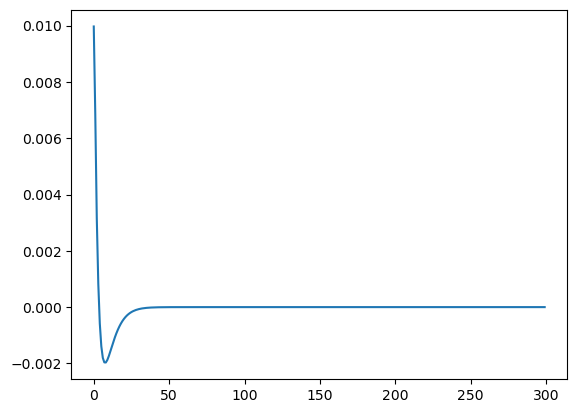

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x10d9a1b10>

In [6]:
goods_mkt_error, impulse = impulse_map(rs, Zs, hh_ss_all_vals, end_T)
plot(goods_mkt_error)

In [7]:
J_r = zeros(end_T, end_T)
h = 1e-4 # small shock to r 
no_shock = impulse_map(rs_ss, Zs, hh_ss_all_vals, end_T)[1]
for tshock in 1:end_T
    r_shock = fill(hh_ss_all_vals["r"], 300)
    r_shock[tshock] = hh_ss_all_vals["r"] + h
    J_r[:, tshock] = (impulse_map(r_shock, Zs, hh_ss_all_vals, end_T)[1] - no_shock) ./ h
    print(tshock, " ")
end

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 

In [8]:
# Shooting Algo. Jacobian
#J_r
max.(J_r - het_Js["C"]["r"])# --> These are the same. J_r (from the shooting algo) uses impulse map while het_Js uses the fake-news algo, this might actually be the right jacobian

300×300 Matrix{Float64}:
 -5.94849e-12  -9.77773e-13  -7.75741e-12  …  -1.71158e-12  -1.71253e-12
 -8.15101e-12   4.80527e-5    5.00274e-6      -1.46543e-12  -1.4646e-12
  1.09247e-11  -8.74746e-6    6.44454e-5      -1.24753e-12  -1.24848e-12
  7.31687e-12  -7.85297e-7   -1.07313e-5      -1.0566e-12   -1.05577e-12
  2.14203e-11  -5.12174e-8   -6.46755e-7      -8.85447e-13  -8.86395e-13
 -8.20187e-12   4.56209e-7    5.64003e-7   …  -7.34756e-13  -7.33924e-13
 -1.12457e-11   7.36205e-7    1.25204e-6      -5.98637e-13  -5.9958e-13
 -5.28839e-12   8.07402e-7    1.55996e-6      -4.78696e-13  -4.77858e-13
  2.21247e-12   7.95874e-7    1.57281e-6      -3.6972e-13   -3.70658e-13
  1.37173e-11   7.32928e-7    1.47938e-6      -2.73843e-13  -2.73001e-13
  3.73888e-12   6.51296e-7    1.32864e-6   …  -1.86272e-13  -1.87205e-13
 -2.04516e-11   5.66713e-7    1.1623e-6       -1.09478e-13  -1.08631e-13
  1.58931e-11   4.8675e-7     1.00055e-6      -3.89477e-14  -3.98772e-14
  ⋮                         

In [12]:
# jacobians
dGoods_dZ = -1 .* I
dGoods_dC = I
J_C_z = het_Js["C"]["z"]
J_C_r = het_Js["C"]["r"]
J_r_rante = I

UniformScaling{Bool}
true*I

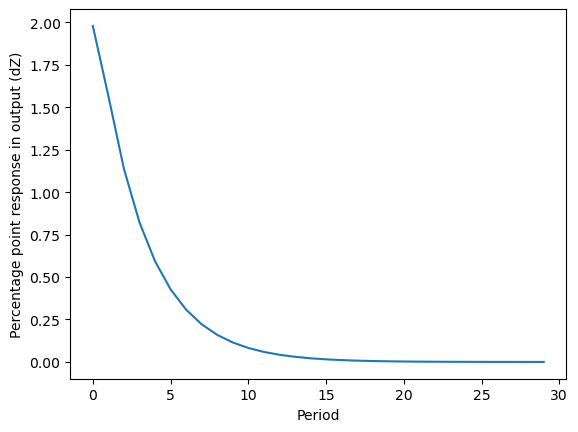

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x119afe500>

In [13]:
# Impulse response without jacobian dimension adjustments
H_r = (dGoods_dC * J_C_r * J_r_rante)
H_z = (dGoods_dZ + (dGoods_dC * J_C_z))
inv_H_z = H_z \ I
dZ = -1 .* inv_H_z * H_r * adj_dr
xlabel("Period")
ylabel("Percentage point response in output (dZ)")
plot(dZ[1:30] .* 100)

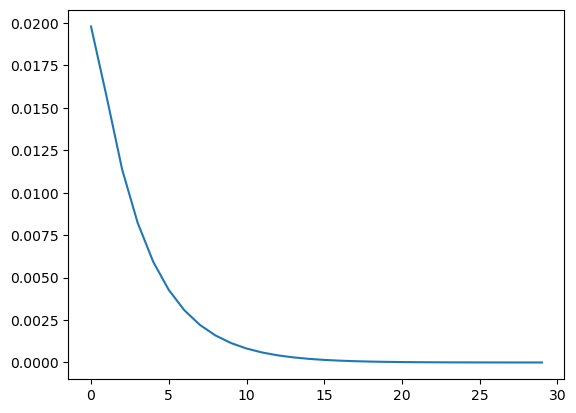

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x119b762c0>

In [14]:
# Impulse response with jacobian dimension adjustments (new)
H_r_new = (dGoods_dC * J_C_r * J_r_rante)[1:end-1, 2:end]
H_z_new = (dGoods_dZ + (dGoods_dC * J_C_z))[1:end-1, 1:end-1]
inv_H_z_new = H_z_new \ I
dZ_new = -1 .* inv_H_z_new * H_r_new * new_dr
plot(dZ[1:30])